In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
zip_path = "/content/drive/MyDrive/cifar10_images.zip"
extract_path = "/content/cifar10_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,TensorDataset
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR

In [ ]:
import os
print(os.listdir("/content/cifar10_images/cifar10_images"))

['train', 'test']


In [ ]:
transform = transforms.Compose([
    transforms.Resize(96),  # Resize images to at least 96x96
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(96, padding=4),  # Crop and resize the image to 96x96 (after resizing)
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

test_transform = transforms.Compose([
    transforms.Resize(96),  # Resize test images to 96x96
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize test images
])

train_dataset = ImageFolder(root="/content/cifar10_images/cifar10_images/train", transform=transform)
test_dataset = ImageFolder(root="/content/cifar10_images/cifar10_images/test", transform=test_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

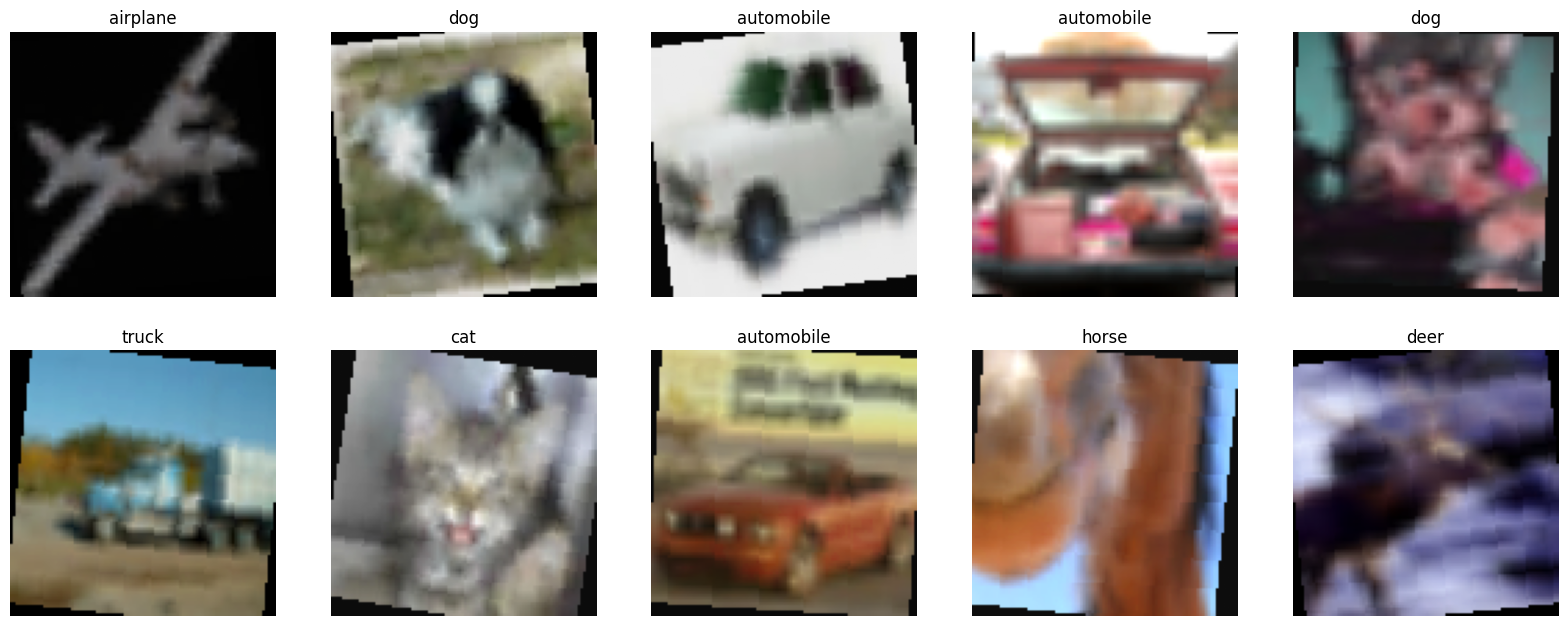

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(10):
    image, label = train_dataset[random.randint(0, len(train_dataset) - 1)]
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.permute(1, 2, 0)/2 + 0.5)
    plt.title(train_dataset.classes[label])
    plt.axis("off")

In [ ]:
class Patch_Linear_Embedding(nn.Module):
    def __init__(self, patch_size=4, embedding_dim=96):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim

        self.proj = nn.Linear(patch_size * patch_size * 3, embedding_dim)


    def forward(self, x):
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5)
        x = x.reshape(x.shape[0] ,x.shape[1],x.shape[2] , self.patch_size * self.patch_size * 3)
        x = self.proj(x)
        return x

In [ ]:
class W_MSA(nn.Module):
    def __init__(self, dim, window_size=6, num_heads=8):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)
    def forward(self, x):
        """
        x: (B, H, W, D)
        """
        B, H, W, D = x.shape
        ws = self.window_size
        x = x.reshape(B, H // ws, ws, W // ws, ws, D)
        x = x.permute(0, 1, 3, 2, 4, 5)
        x = x.reshape(-1, ws * ws, D)


        M, V, C = x.shape  # [total, ws * ws, dim]
        qkv = self.qkv(x)  # [total, ws * ws, 3 * dim]
        qkv = qkv.reshape(M, V, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, total, heads, ws * ws, head_dim]

        q, k, v = qkv[0], qkv[1], qkv[2]  # each: [total, heads, ws * ws, head_dim]

        # Attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [total, heads, ws * ws, ws * ws]
        attn = torch.softmax(scores, dim=-1)

        # Weighted sum of values
        out = torch.matmul(attn, v)  # [total, heads, ws * ws, head_dim]
        out = out.permute(0, 2, 1, 3).reshape(M, V, C)  # [total, ws * ws, dim]

        # Reverse the window partitioning
        out = out.reshape(B, H // ws, W // ws, ws, ws, D)  # [B, H//ws, W//ws, ws, ws, D]
        out = out.permute(0, 1, 3, 2, 4, 5)  # [B, H//ws, W//ws, D, ws, ws]
        out = out.reshape(B, H, W, D)  # [B, H, W, D] - Reconstructed
        return out


In [ ]:
def mask(B, H, W,ss,ws):
    mask = torch.zeros(B, H, W, dtype=torch.int)
    mask[:, :ss, :ss] = 0
    mask[:, :ss, ss:] = 1
    mask[:, ss:, :ss] = 2
    mask[:, ss:, ss:] = 3
    shift_size = ss
    shifted_mask = torch.roll(mask, shifts=(-shift_size, -shift_size), dims=(1, 2))
    shifted_mask = shifted_mask.reshape(B, H // ws, ws, W // ws, ws)
    shifted_mask = shifted_mask.permute(0, 1, 3, 2, 4)
    shifted_mask = shifted_mask.reshape(-1, ws * ws)
    N, L = shifted_mask.shape
    eq = shifted_mask.unsqueeze(2) == shifted_mask.unsqueeze(1)
    attn_mask = torch.where(eq, torch.tensor(0.0), torch.tensor(float('-inf')))
    return attn_mask

In [ ]:
class SW_MSA(nn.Module):
    def __init__(self, dim, window_size=6, shift_size=3, num_heads=8):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        """
        x: (B, H, W, D)
        """
        B, H, W, D = x.shape
        ws = self.window_size
        ss = self.shift_size
        x = torch.roll(x, shifts=(-ss, -ss), dims=(1, 2))


        attn_mask = mask(B, H, W, ss, ws).to(x.device)



        x = x.reshape(B, H // ws, ws, W // ws, ws, D)
        x = x.permute(0, 1, 3, 2, 4, 5)
        x = x.reshape(-1, ws * ws, D)

        M, V, C = x.shape  # [total, ws * ws, dim]
        qkv = self.qkv(x)  # [total, ws * ws, 3 * dim]
        qkv = qkv.reshape(M, V, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, total, heads, ws * ws, head_dim]

        q, k, v = qkv[0], qkv[1], qkv[2]  # each: [total, heads, ws * ws, head_dim]

        # Attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [total, heads, ws * ws, ws * ws]
        scores = scores + attn_mask.unsqueeze(1)
        attn = torch.softmax(scores, dim=-1)
        # Weighted sum of values
        out = torch.matmul(attn, v)# [total, heads, ws * ws, head_dim]
        out = out.permute(0, 2, 1, 3).reshape(M, V, C)

        # Reverse the window partitioning
        out = out.reshape(B, H // ws, W // ws, ws, ws, D)
        out = out.permute(0, 1, 3, 2, 4, 5)
        out = out.reshape(B, H, W, D)
        out = torch.roll(out, shifts=(ss, ss), dims=(1, 2))
        out = self.proj(out)
        return out

In [ ]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads = 8, window_size=6, shift_size=3):
        super().__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.norm1 = nn.LayerNorm(dim)
        self.attn1 = W_MSA(dim, num_heads=num_heads, window_size=window_size)

        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)
        self.norm4 = nn.LayerNorm(dim)
        self.mlp1 = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.attn2 = SW_MSA(dim, num_heads=num_heads, window_size=window_size, shift_size=shift_size)


        self.mlp2 = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )



    def forward(self, x):
        B, H, W, C = x.shape

        x = x + self.attn1(self.norm1(x))
        x = x + self.mlp1(self.norm2(x))
        x = x + self.attn2(self.norm3(x))
        x = x + self.mlp2(self.norm4(x))
        return x

In [ ]:
class PatchMerging(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.reduction = nn.Linear(4 * input_dim, 2 * input_dim, bias=False)
        self.norm = nn.LayerNorm(4 * input_dim)

    def forward(self, x):
        B, H, W, C = x.shape

        # Step 1: reshape 2x2 patches into one
        x0 = x[:, 0::2, 0::2, :]  # top-left
        x1 = x[:, 0::2, 1::2, :]  # top-right
        x2 = x[:, 1::2, 0::2, :]  # bottom-left
        x3 = x[:, 1::2, 1::2, :]  # bottom-right
        # Step 2: concatenate along the channel dimension
        x_merged = torch.cat([x0, x1, x2, x3], dim=-1)  # Shape: [B, H/2, W/2, 4C]
        # Step 3: normalization and linear projection to reduce dim
        x_merged = self.norm(x_merged)
        x_merged = self.reduction(x_merged)  # Shape: [B, H/2, W/2, 2C]
        return x_merged



In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim=384, num_classes=10):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # pools HxW to 1x1
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x shape: [B, H, W, C] → convert to [B, C, H, W]
        x = x.permute(0, 3, 1, 2)
        x = self.avg_pool(x)           # [B, C, 1, 1]
        x = x.reshape(x.size(0), -1)      # [B, Cx1x1]
        return self.fc(x)              # [B, num_classes]


In [ ]:
class SimpleSwinTransformer(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.embedding = Patch_Linear_Embedding(patch_size=4, embedding_dim=96)
        self.stb1 = SwinTransformerBlock(dim=96, window_size=6, shift_size=3, num_heads=8)
        self.stb2 = SwinTransformerBlock(dim=96, window_size=6, shift_size=3, num_heads=8)
        self.stb3 = SwinTransformerBlock(dim=192, window_size=6, shift_size=3, num_heads=8)
        self.stb4 = SwinTransformerBlock(dim=192, window_size=6, shift_size=3, num_heads=8)
        self.stb5 = W_MSA(dim = 384, window_size=6, num_heads=8)
        self.stb6 = W_MSA(dim = 384, window_size=6, num_heads=8)
        self.patch_merging1 = PatchMerging(input_dim=96)
        self.patch_merging2 = PatchMerging(input_dim=192)
        self.classification_head = ClassificationHead(embed_dim=384, num_classes=num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.stb1(x)
        x = self.stb2(x)
        x = self.patch_merging1(x)
        x = self.stb3(x)
        x = self.stb4(x)
        x = self.patch_merging2(x)
        x = self.stb5(x)
        x = self.stb6(x)
        x = self.classification_head(x)
        return x



In [ ]:
# Warm-up function to increase the learning rate gradually
def warmup_lr(epoch, warmup_epochs, initial_lr=1e-3):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs * initial_lr  # Linear warmup
    return initial_lr

# Learning rate scheduler for warm-up and cosine annealing
def get_scheduler(epoch, warmup_scheduler, cosine_scheduler, warmup_epochs):
    if epoch < warmup_epochs:
        warmup_scheduler.step(epoch)
    else:
        cosine_scheduler.step()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSwinTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# Number of warm-up epochs and total training epochs
warmup_epochs = 5
total_epochs = 20
T_max = total_epochs - warmup_epochs  # Total number of epochs for Cosine Annealing after warmup

# Warm-up scheduler
warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_lr(epoch, warmup_epochs))

# Cosine annealing scheduler
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=1e-6)


In [ ]:
# Training function
def train(model, loader, optimizer, criterion, epoch, warmup_scheduler, cosine_scheduler, warmup_epochs):
    model.train()
    total_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for imgs, labels in tqdm(loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)     # [B, 10]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Train Loss: {avg_loss:.4f}")

    # Update learning rate after each epoch
    get_scheduler(epoch, warmup_scheduler, cosine_scheduler, warmup_epochs)

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")

In [ ]:
#  Training loop
for epoch in range(1, total_epochs + 1):
    # Train for one epoch
    train(model, train_loader, optimizer, criterion, epoch, warmup_scheduler, cosine_scheduler, warmup_epochs)

    # Evaluate the model on the test set
    evaluate(model, test_loader)

    # Save model after each epoch (optional)
    model_save_path = f"/content/drive/MyDrive/simple_swin_epoch{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

Epoch 1: 100%|██████████| 782/782 [02:26<00:00,  5.34it/s]

Train Loss: 2.2797



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test Accuracy: 19.08%
Model saved to /content/drive/MyDrive/simple_swin_epoch1.pth


Epoch 2: 100%|██████████| 782/782 [02:24<00:00,  5.39it/s]

Train Loss: 2.2076


Test Accuracy: 22.75%
Model saved to /content/drive/MyDrive/simple_swin_epoch2.pth


Epoch 3: 100%|██████████| 782/782 [02:26<00:00,  5.34it/s]

Train Loss: 2.0969


Test Accuracy: 25.54%
Model saved to /content/drive/MyDrive/simple_swin_epoch3.pth


Epoch 4: 100%|██████████| 782/782 [02:25<00:00,  5.36it/s]

Train Loss: 2.0324


Test Accuracy: 26.66%
Model saved to /content/drive/MyDrive/simple_swin_epoch4.pth


Epoch 5: 100%|██████████| 782/782 [02:25<00:00,  5.38it/s]

Train Loss: 1.9965


Test Accuracy: 28.57%
Model saved to /content/drive/MyDrive/simple_swin_epoch5.pth


Epoch 6: 100%|██████████| 782/782 [02:24<00:00,  5.40it/s]

Train Loss: 1.9652


Test Accuracy: 29.91%
Model saved to /content/drive/MyDrive/simple_swin_epoch6.pth


Epoch 7: 100%|██████████| 782/782 [02:24<00:00,  5.40it/s]

Train Loss: 1.9394


Test Accuracy: 30.61%
Model saved to /content/drive/MyDrive/simple_swin_epoch7.pth


Epoch 8: 100%|██████████| 782/782 [02:24<00:00,  5.41it/s]

Train Loss: 1.9177


Test Accuracy: 31.40%
Model saved to /content/drive/MyDrive/simple_swin_epoch8.pth


Epoch 9: 100%|██████████| 782/782 [02:24<00:00,  5.42it/s]

Train Loss: 1.8959


Test Accuracy: 32.04%
Model saved to /content/drive/MyDrive/simple_swin_epoch9.pth


Epoch 10: 100%|██████████| 782/782 [02:24<00:00,  5.39it/s]

Train Loss: 1.8769


Test Accuracy: 32.49%
Model saved to /content/drive/MyDrive/simple_swin_epoch10.pth


Epoch 11: 100%|██████████| 782/782 [02:26<00:00,  5.33it/s]

Train Loss: 1.8597


Test Accuracy: 32.81%
Model saved to /content/drive/MyDrive/simple_swin_epoch11.pth


Epoch 12: 100%|██████████| 782/782 [02:25<00:00,  5.36it/s]

Train Loss: 1.8452


Test Accuracy: 32.99%
Model saved to /content/drive/MyDrive/simple_swin_epoch12.pth


Epoch 13: 100%|██████████| 782/782 [02:25<00:00,  5.38it/s]

Train Loss: 1.8306


Test Accuracy: 33.30%
Model saved to /content/drive/MyDrive/simple_swin_epoch13.pth


Epoch 14: 100%|██████████| 782/782 [02:25<00:00,  5.39it/s]

Train Loss: 1.8174


Test Accuracy: 33.95%
Model saved to /content/drive/MyDrive/simple_swin_epoch14.pth


Epoch 15: 100%|██████████| 782/782 [02:25<00:00,  5.38it/s]

Train Loss: 1.8043


Test Accuracy: 33.84%
Model saved to /content/drive/MyDrive/simple_swin_epoch15.pth


Epoch 16: 100%|██████████| 782/782 [02:25<00:00,  5.38it/s]

Train Loss: 1.7866


Test Accuracy: 34.23%
Model saved to /content/drive/MyDrive/simple_swin_epoch16.pth


Epoch 17: 100%|██████████| 782/782 [02:24<00:00,  5.40it/s]

Train Loss: 1.7729


Test Accuracy: 34.78%
Model saved to /content/drive/MyDrive/simple_swin_epoch17.pth


Epoch 18: 100%|██████████| 782/782 [02:25<00:00,  5.36it/s]

Train Loss: 1.7597


Test Accuracy: 35.46%
Model saved to /content/drive/MyDrive/simple_swin_epoch18.pth


Epoch 19: 100%|██████████| 782/782 [02:26<00:00,  5.35it/s]

Train Loss: 1.7447


Test Accuracy: 35.90%
Model saved to /content/drive/MyDrive/simple_swin_epoch19.pth


Epoch 20: 100%|██████████| 782/782 [02:24<00:00,  5.43it/s]

Train Loss: 1.7298


Test Accuracy: 35.76%
Model saved to /content/drive/MyDrive/simple_swin_epoch20.pth


In [ ]:
#  Training loop
for epoch in range(21, 51):
    # Train for one epoch
    train(model, train_loader, optimizer, criterion, epoch, warmup_scheduler, cosine_scheduler, warmup_epochs)

    # Evaluate the model on the test set
    evaluate(model, test_loader)

    # Save model after each epoch (optional)
    model_save_path = f"/content/drive/MyDrive/simple_swin_epoch{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

Epoch 21: 100%|██████████| 782/782 [02:25<00:00,  5.38it/s]

Train Loss: 1.7197


Test Accuracy: 39.57%
Model saved to /content/drive/MyDrive/simple_swin_epoch21.pth


Epoch 22: 100%|██████████| 782/782 [02:23<00:00,  5.43it/s]

Train Loss: 1.6615


Test Accuracy: 42.35%
Model saved to /content/drive/MyDrive/simple_swin_epoch22.pth


Epoch 23: 100%|██████████| 782/782 [02:24<00:00,  5.40it/s]

Train Loss: 1.5459


Test Accuracy: 47.52%
Model saved to /content/drive/MyDrive/simple_swin_epoch23.pth


Epoch 24: 100%|██████████| 782/782 [02:25<00:00,  5.39it/s]

Train Loss: 1.4197


Test Accuracy: 49.92%
Model saved to /content/drive/MyDrive/simple_swin_epoch24.pth


Epoch 25: 100%|██████████| 782/782 [02:25<00:00,  5.37it/s]

Train Loss: 1.3139


Test Accuracy: 55.90%
Model saved to /content/drive/MyDrive/simple_swin_epoch25.pth


Epoch 26: 100%|██████████| 782/782 [02:25<00:00,  5.38it/s]

Train Loss: 1.2212


Test Accuracy: 57.18%
Model saved to /content/drive/MyDrive/simple_swin_epoch26.pth


Epoch 27: 100%|██████████| 782/782 [02:24<00:00,  5.39it/s]

Train Loss: 1.1540


Test Accuracy: 59.76%
Model saved to /content/drive/MyDrive/simple_swin_epoch27.pth


Epoch 28: 100%|██████████| 782/782 [02:24<00:00,  5.40it/s]

Train Loss: 1.1450


Test Accuracy: 60.17%
Model saved to /content/drive/MyDrive/simple_swin_epoch28.pth


Epoch 29: 100%|██████████| 782/782 [02:23<00:00,  5.44it/s]

Train Loss: 1.2214


Test Accuracy: 50.07%
Model saved to /content/drive/MyDrive/simple_swin_epoch29.pth


Epoch 30: 100%|██████████| 782/782 [02:24<00:00,  5.40it/s]

Train Loss: 1.7717


Test Accuracy: 20.00%
Model saved to /content/drive/MyDrive/simple_swin_epoch30.pth


Epoch 31: 100%|██████████| 782/782 [02:26<00:00,  5.34it/s]

Train Loss: 2.1439


Test Accuracy: 18.25%
Model saved to /content/drive/MyDrive/simple_swin_epoch31.pth


Epoch 32: 100%|██████████| 782/782 [02:25<00:00,  5.39it/s]

Train Loss: 2.0269


Test Accuracy: 27.39%
Model saved to /content/drive/MyDrive/simple_swin_epoch32.pth


Epoch 33: 100%|██████████| 782/782 [02:26<00:00,  5.34it/s]

Train Loss: 2.0391


Test Accuracy: 13.65%
Model saved to /content/drive/MyDrive/simple_swin_epoch33.pth


Epoch 34: 100%|██████████| 782/782 [02:26<00:00,  5.35it/s]

Train Loss: 2.0701


Test Accuracy: 24.02%
Model saved to /content/drive/MyDrive/simple_swin_epoch34.pth


Epoch 35: 100%|██████████| 782/782 [02:25<00:00,  5.37it/s]

Train Loss: 2.2431


Test Accuracy: 20.38%
Model saved to /content/drive/MyDrive/simple_swin_epoch35.pth


Epoch 36: 100%|██████████| 782/782 [02:25<00:00,  5.36it/s]

Train Loss: 2.0671


Test Accuracy: 22.24%
Model saved to /content/drive/MyDrive/simple_swin_epoch36.pth


Epoch 37: 100%|██████████| 782/782 [02:24<00:00,  5.40it/s]

Train Loss: 1.9972


Test Accuracy: 25.87%
Model saved to /content/drive/MyDrive/simple_swin_epoch37.pth


Epoch 38: 100%|██████████| 782/782 [02:25<00:00,  5.37it/s]

Train Loss: 1.9374


Test Accuracy: 28.43%
Model saved to /content/drive/MyDrive/simple_swin_epoch38.pth


Epoch 39: 100%|██████████| 782/782 [02:26<00:00,  5.33it/s]

Train Loss: 2.0554


Test Accuracy: 21.63%
Model saved to /content/drive/MyDrive/simple_swin_epoch39.pth


Epoch 40: 100%|██████████| 782/782 [02:26<00:00,  5.34it/s]

Train Loss: 2.1177


Test Accuracy: 21.21%
Model saved to /content/drive/MyDrive/simple_swin_epoch40.pth


Epoch 41: 100%|██████████| 782/782 [02:26<00:00,  5.33it/s]

Train Loss: 2.1281


Test Accuracy: 21.15%
Model saved to /content/drive/MyDrive/simple_swin_epoch41.pth


Epoch 42: 100%|██████████| 782/782 [02:26<00:00,  5.32it/s]

Train Loss: 2.0819


Test Accuracy: 21.83%
Model saved to /content/drive/MyDrive/simple_swin_epoch42.pth


Epoch 43: 100%|██████████| 782/782 [02:26<00:00,  5.33it/s]

Train Loss: 2.0562


Test Accuracy: 25.26%
Model saved to /content/drive/MyDrive/simple_swin_epoch43.pth


Epoch 44: 100%|██████████| 782/782 [02:27<00:00,  5.29it/s]

Train Loss: 2.0533


Test Accuracy: 23.49%
Model saved to /content/drive/MyDrive/simple_swin_epoch44.pth


Epoch 45: 100%|██████████| 782/782 [02:26<00:00,  5.34it/s]

Train Loss: 2.0409


Test Accuracy: 23.78%
Model saved to /content/drive/MyDrive/simple_swin_epoch45.pth


Epoch 46: 100%|██████████| 782/782 [02:26<00:00,  5.35it/s]

Train Loss: 2.0263


Test Accuracy: 23.68%
Model saved to /content/drive/MyDrive/simple_swin_epoch46.pth


Epoch 47: 100%|██████████| 782/782 [02:25<00:00,  5.38it/s]

Train Loss: 2.0102


Test Accuracy: 23.40%
Model saved to /content/drive/MyDrive/simple_swin_epoch47.pth


Epoch 48: 100%|██████████| 782/782 [02:26<00:00,  5.35it/s]

Train Loss: 1.9962


Test Accuracy: 25.32%
Model saved to /content/drive/MyDrive/simple_swin_epoch48.pth


Epoch 49: 100%|██████████| 782/782 [02:26<00:00,  5.34it/s]

Train Loss: 1.9854


Test Accuracy: 25.83%
Model saved to /content/drive/MyDrive/simple_swin_epoch49.pth


Epoch 50: 100%|██████████| 782/782 [02:24<00:00,  5.40it/s]

Train Loss: 1.9797


Test Accuracy: 26.14%
Model saved to /content/drive/MyDrive/simple_swin_epoch50.pth


In [ ]:
import os
os.listdir("/content/drive/MyDrive")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

def epoch_vs_accuracy(device):
    accuracy_test = []
    accuracy_train = []

    for i in tqdm(range(1, 31), desc="Evaluating Epochs"):
        # Load model
        swin = SimpleSwinTransformer(num_classes=10).to(device)
        checkpoint_path = f'/content/drive/MyDrive/simple_swin_epoch{i}.pth'
        swin.load_state_dict(torch.load(checkpoint_path, map_location=device))
        swin.eval()

        # --- Test Accuracy ---
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = swin(images)
                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)
        acc_test = 100 * correct_test / total_test
        accuracy_test.append(acc_test)

        # --- Train Accuracy ---
        correct_train = 0
        total_train = 0
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = swin(images)
                _, predicted = outputs.max(1)
                correct_train += predicted.eq(labels).sum().item()
                total_train += labels.size(0)
        acc_train = 100 * correct_train / total_train
        accuracy_train.append(acc_train)

        # Print progress
        print(f"Epoch {i}: Train Acc = {acc_train:.2f}%, Test Acc = {acc_test:.2f}%")

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 31), accuracy_train, label='Train Accuracy')
    plt.plot(range(1, 31), accuracy_test, label='Test Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Epoch vs Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save to Google Drive
    plt.savefig("/content/drive/MyDrive/epoch_vs_accuracy.png")
    plt.close()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epoch_vs_accuracy(device)

Evaluating Epochs:   0%|          | 0/30 [05:41<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSwinTransformer().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/simple_swin_epoch28.pth", map_location=device))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
all_labels = []
all_preds = []
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

    # Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, output_dict=True)

    # Save metrics to text file
with open(f"/content/drive/MyDrive/metric2.txt", 'w') as f:
    f.write("Accuracy: {:.2f}%\n".format(accuracy * 100))
    f.write("Precision: {:.2f}\n".format(precision))
    f.write("Recall: {:.2f}\n".format(recall))
    f.write("F1 Score: {:.2f}\n".format(f1))
    f.write("\nConfusion Matrix:\n")
    f.write(np.array2string(cm))
    f.write("\n\nClassification Report:\n")
    for label, metrics in report.items():
        f.write(f"Label {label}: {metrics}\n")

    # Save confusion matrix plot
    plt.figure(figsize=(10, 8))
    classes = [str(i) for i in range(10)]  # for MNIST
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/confusion_matrix_metric2.png")
    plt.close()